# Update_model throws an error

In another notebook, I was trying to vary the image distance and plot the spot diagram. But after just a few iterations of varying the distance and calling `update_model()` on the `OpticalModel`, it threw an error. After further investigation, I found that just calling `update_model()` more than 5 times without even changing anything threw the same error. This notebook is my attempt to make a minimum reproducible example (MRE) to demonstrate the problem.

Results: The error happens within `EvenPolynomial.sag`, which sounds like it has to do with the aspheric properties of the lens. I couldn't reproduce the problem with just a single achromatic doublet lens. But it is reproducible with the single aspheric lens imported here.

I tried running `update_model()` multiple times on the 'Cell Phone lens' notebook from [here](https://github.com/mjhoptics/ray-optics-notebooks/blob/master/Cell%20Phone%20lens.ipynb), and it did not throw the same error (although that notebook must be written for an older version of rayoptics than I have (0.9.2) because it threw other errors). That implies that maybe something is wrong with the `OpticalModel` produced by importing the .seq file from Edmund Optics. But I don't know enough to figure out what that might be.

In [1]:
%matplotlib widget
from rayoptics.environment import *
root_pth = Path(rayoptics.__file__).resolve().parent
lens_folder = Path().parent / "Lens files"

desired_wavelength = 930 # nm
laser_beam_dia = 4

## Import aspheric singlet lens

We import the lens from a Code V file for a stock aspheric singlet from Edmund optics. This notebook assumes that the file is stored in a subfolder called "Lens files". If you put the .SEQ file somewhere else, you'll need to modify the `lens_folder` variable defined above.

The lens file was obtained from the following URL: https://www.edmundoptics.com/p/9mm-dia-x-30mm-fl-nir-ii-coated-achromatic-lens/7442/


In [2]:
opm2 = OpticalModel()
sm2  = opm2['seq_model']
osp2 = opm2['optical_spec']
pm2 = opm2['parax_model']
em2 = opm2['ele_model']
pt2 = opm2['part_tree']
ar2 = opm2['analysis_results']

pupil_dia2 = laser_beam_dia

max_angle2 = 5
nominal_efl2 = 8

osp2['pupil'] = PupilSpec(osp2, key=['object', 'epd'], value=pupil_dia2)
osp2['fov'] = FieldSpec(osp2, key=['object', 'angle'], value=max_angle2, flds=[0.0, 0.5, 1.0], is_relative=True)
osp2['wvls'] = WvlSpec([(desired_wavelength, 1.0)], ref_wl=0)

sm2.gaps[0].thi=1e10

opm2.update_model()

opm2.add_from_file(lens_folder / "Edmund_CODV_46377.seq", t=10)
    # Aspheric, EFL = 8 mm, WD(BFL) = 5.94 mm, CA = 8 mm, OD = 9.94 mm, design = 780 nm, Glass: ECO-550, Edmund stock #46-377
    # ERROR: Does not import glass type correctly (or maybe the .seq file doesn't list it). The medium is just air.
    # The glass can be fixed with an `InterpolatedMedium` with the index data from the ECO-550 datasheet found here:
    # https://www.edmundoptics.com/viewdocument/ECO-550.pdf

# Fixing the incorrect glass import.
n_vs_wavelength = [(1970, 1.578),(1530,1.579),(1129,1.588),(1060,1.589),(1014,1.590),(852,1.593),(768,1.595),(707,1.597),(656,1.599),(644,1.600),(633,1.600),(589,1.603),(588,1.603),(546,1.606),(486,1.611),(480,1.612),(436,1.618),(405,1.624),(365,1.633)]
ECO550 = InterpolatedMedium('ECO-550', cat='LightPath', pairs=n_vs_wavelength)

sm2.gaps[1].medium = ECO550
opm2.update_model()

# The .seq file also contains cover glass for some reason.
# Remove the 2 surfaces of the cover glass, remembering to count backwards.
sm2.remove(4) # The final surface of the cover glass.
sm2.remove(3) # The first surface of the cover glass.
opm2.update_model()

# Adjust the final thickness of air to match the objective's BFL
obj_bfl = ar2['parax_data'].fod.bfl   #5.893 # From examining first-order data.
least_conf_delta = -0.0753  # Adjustment to put the image plane at the circle of least confusion found from the layout plot.
sm2.gaps[-1].thi = obj_bfl + least_conf_delta
opm2.update_model()

In [3]:
sm2.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1  8.7489e+08
46377:     0.197294      3.69000   ECO-550             1      4.0000
    2:    -0.016347      5.81728       air             1      4.0000
  Img:     0.000000      0.00000                       1     0.72369


In [4]:
pm2.first_order_data()

efl               8.079
f                 8.079
f'                8.079
ffl              -7.898
pp1              0.1811
bfl               5.893
ppk              -2.186
pp sep            1.323
f/#                2.02
m            -8.079e-10
red          -1.238e+09
obj_dist          1e+10
obj_ang               5
enp_dist             -0
enp_radius            2
na obj            2e-10
n obj                 1
img_dist          5.893
img_ht           0.7068
exp_dist         -2.296
exp_radius        2.046
na img          -0.2476
n img                 1
optical invariant        0.175


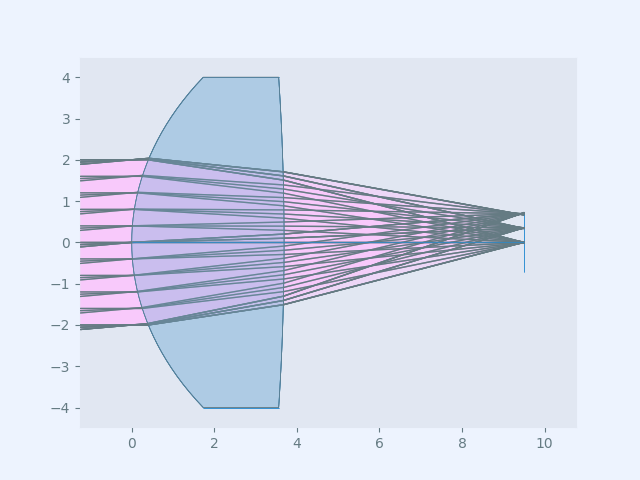

In [5]:
layout_plt2 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm2, do_draw_rays=True, 
                         do_draw_ray_fans=True, do_draw_frame=True, do_paraxial_layout=False).plot()

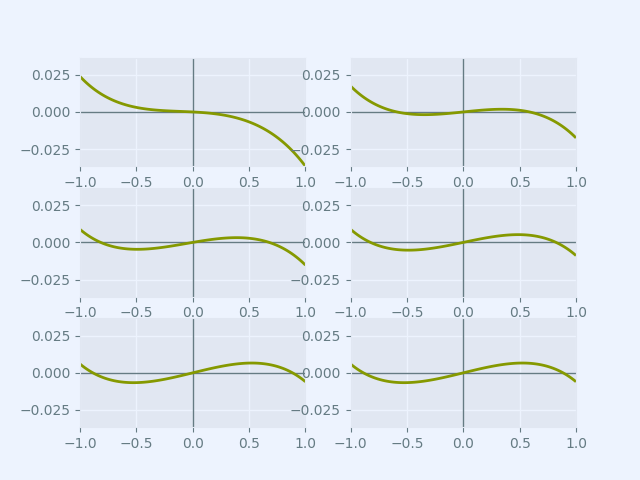

In [6]:
abr_plt2 = plt.figure(FigureClass=RayFanFigure, opt_model=opm2, data_type='Ray', scale_type=Fit.All_Same).plot()

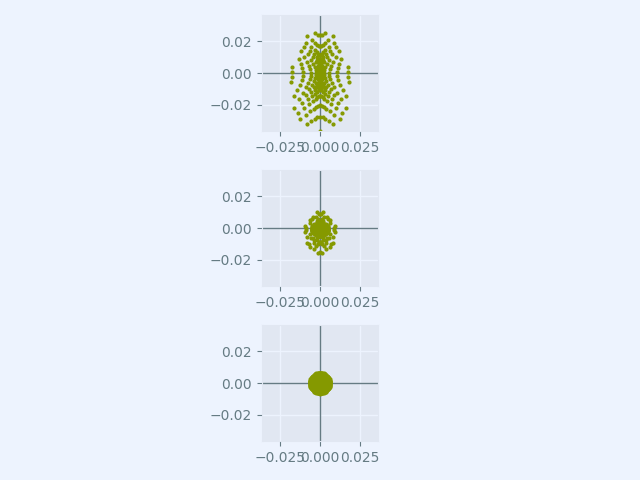

In [7]:
spot_plt2 = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm2,
                      scale_type=Fit.All_Same, is_dark=False).plot()

## Run `update_model()` several times without changing anything

In [8]:
for idx in range(6):
    opm2.update_model()
    print(f'Model successfully updated {idx+1} times.')

Model successfully updated 1 times.
Model successfully updated 2 times.
Model successfully updated 3 times.
Model successfully updated 4 times.
Model successfully updated 5 times.


c:\ProgramData\anaconda3\envs\rayoptics\Lib\site-packages\rayoptics\seq\sequential.py:35: SyntaxWarning: invalid escape sequence '\ '
  """ Manager class for a sequential optical model
c:\ProgramData\anaconda3\envs\rayoptics\Lib\site-packages\rayoptics\raytr\trace.py:762: SyntaxWarning: invalid escape sequence '\|'
  """ intersect 2 non-parallel lines, returning distance from P1
c:\ProgramData\anaconda3\envs\rayoptics\Lib\site-packages\rayoptics\elem\profiles.py:436: SyntaxWarning: invalid escape sequence '\s'
  """ Conic surface profile parameterized by curvature and conic constant.
c:\ProgramData\anaconda3\envs\rayoptics\Lib\site-packages\rayoptics\elem\profiles.py:659: SyntaxWarning: invalid escape sequence '\s'
  """ Even Polynomial asphere, even terms up to 20th order, on base conic.
c:\ProgramData\anaconda3\envs\rayoptics\Lib\site-packages\rayoptics\elem\profiles.py:871: SyntaxWarning: invalid escape sequence '\s'
  """ Radial Polynomial asphere, both even and odd terms, on base 

IndexError: list index out of range

We see that without even changing anything in the model, running `update_model()` more than 5 times causes an error. Any subsequent calls to `update_model()` throw the same error.

In [ ]:
opm2.update_model()

IndexError: list index out of range

## Loop through different image distances

This section contains what I would like to do, but similar to above, running `update_model()` more than 5 times throws an error. (You would have to comment out the above section to get to this section while avoiding the error.)

Save the original image distance.

In [ ]:
orig_img_dist = sm2.gaps[-1].thi
print(f'Original image distance is: {orig_img_dist}')

Original image distance is: 55.796144195514785


Restrict our analysis to just the zero-field-angle to simplify the plots.

In [ ]:
osp2['fov'] = FieldSpec(osp2, key=['object', 'angle'], value=max_angle2, flds=[0.0], is_relative=True)
opm2.update_model()

Vary the image distance by some `max_defocus` around the original image distance and plot the spot diagrams.

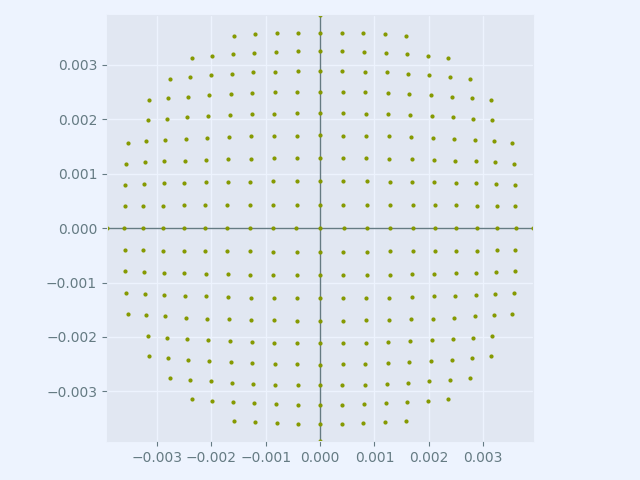

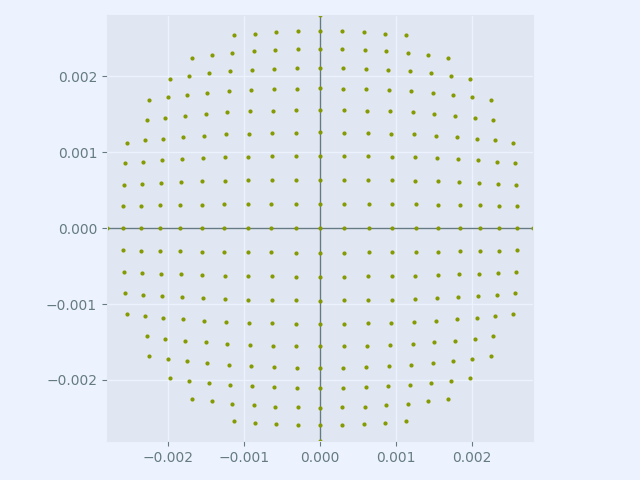

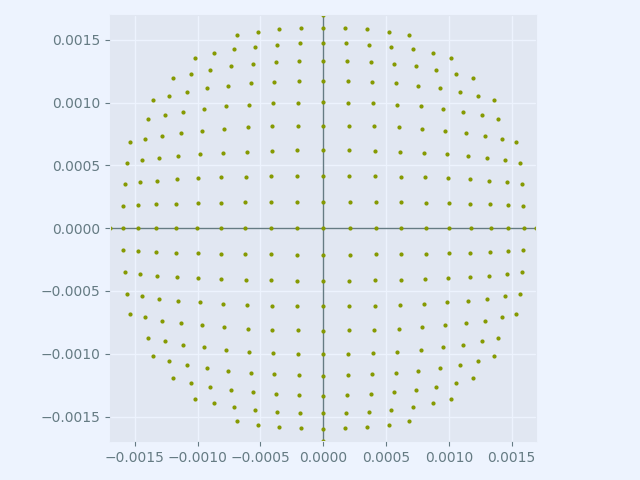

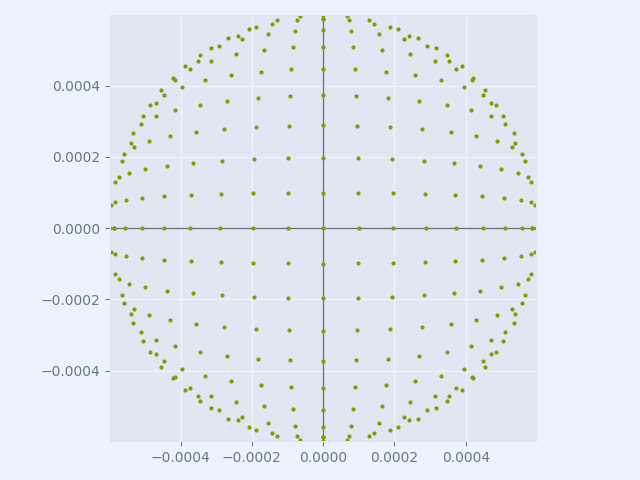

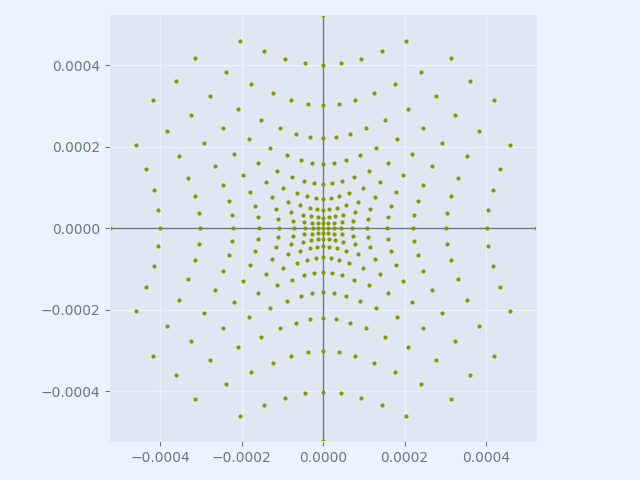

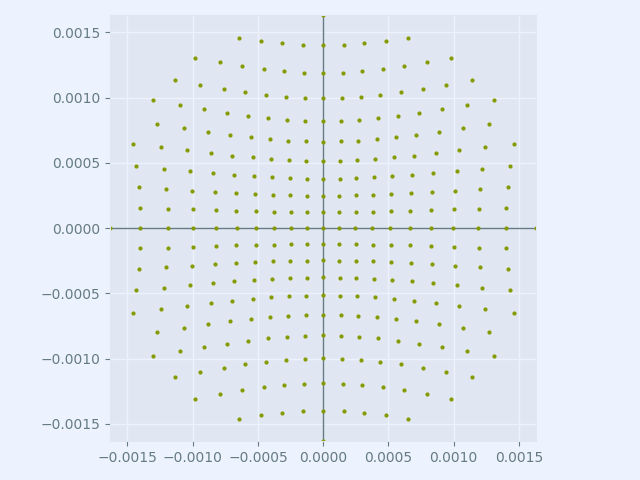

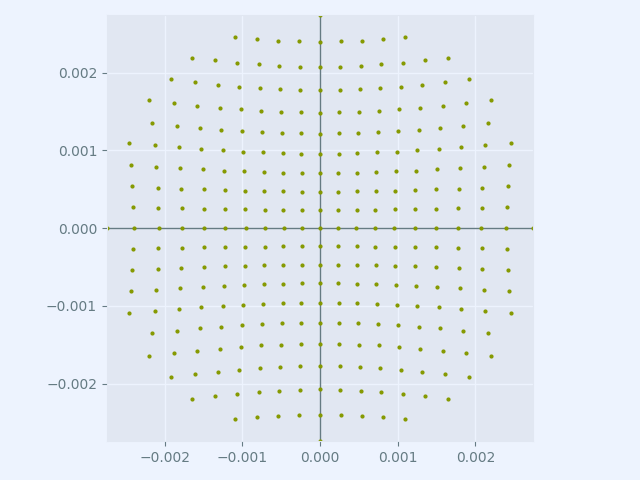

In [ ]:
num_defocus = 7
max_defocus = 0.1
defocuses = np.linspace(-max_defocus,max_defocus,num_defocus)
spot_diagrams = []
for idx, defocus in enumerate(defocuses):
   sm2.gaps[-1].thi = orig_img_dist + defocus
   opm2.update_model()
   temp_plot = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm2,
                     scale_type=Fit.All_Same, is_dark=False).plot()
   spot_diagrams.append(temp_plot)

If `num_defocus` is greater than 5, then `update_model()` will throw an error on the 6th call.